## Combining LLM Vision-based Data Extraction with Instructor Validation

Recent advancements in AI have opened up exciting new possibilities for extracting data from complex documents. By leveraging powerful vision models, we can now "read" information from richly formatted sources like PDFs in a more intuitive and flexible way compared to traditional parsing techniques.

The advantage of this vision-based approach is that multimodal models can natively understand sophisticated layouts, tables, and visual elements without relying on brittle rules or templates. This allows for more generalized extraction across a wider variety of documents.
However, in experimenting with these cutting-edge methods, one challenge has emerged - vision models exhibit a greater tendency to "hallucinate" text or values that don't actually appear in the source document.

Fortunately, there's a solution! By combining vision-based extraction with validation techniques, we can programmatically check the extracted data against the original document to identify any instances of hallucination. This allows us to surface and handle potential inaccuracies. In this notebook we will show how to implement this using as example a PDF document with complex formt. 

Let's first import all the required dependencis and initialize the model client. For this notebook we will be using Gemini-1.5-flash, since Google's modes are quite easy to work with in multimodal scenarios like this one. 

In [26]:
from pydantic import BaseModel, field_validator, Field
from typing import ClassVar
import instructor
import google.generativeai as genai
from dotenv import load_dotenv
from pdf2image import convert_from_path
from pypdf import PdfReader
import os
from IPython.display import IFrame
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_STUDIO_KEY"))

MODEL = "gemini-1.5-flash-latest"



## The target document
Let's dive into the specifics of the document we're working with - a utility bill for a house in Spain. As you can see from the images below, the bill has a fairly complex layout with tables, headers, and fine print that would be challenging to parse using traditional methods.

Since our source document is a PDF, the first step is to convert each page into an image. This allows us to feed the visual layout of the bill into our extraction model. The `pdf_to_images` function handles this conversion, generating one PNG file per page.
Take a look at the resulting images to get a sense of the document format we're dealing with:

As you can see, the bill includes key information like the total amount due, energy consumption details, and the contracted power, but it's not in a straightforward text format. This is where the power of vision-based extraction comes into play - our model can "read" this complex layout to identify and extract the relevant data points.

In the next step, we'll upload these images and craft our extraction prompt to zero in on the specific fields we need from this challenging document.

Saved page 1 to ./working files/pdf_images/page_1.png
Saved page 2 to ./working files/pdf_images/page_2.png
Saved page 3 to ./working files/pdf_images/page_3.png
Successfully converted 3 pages to images


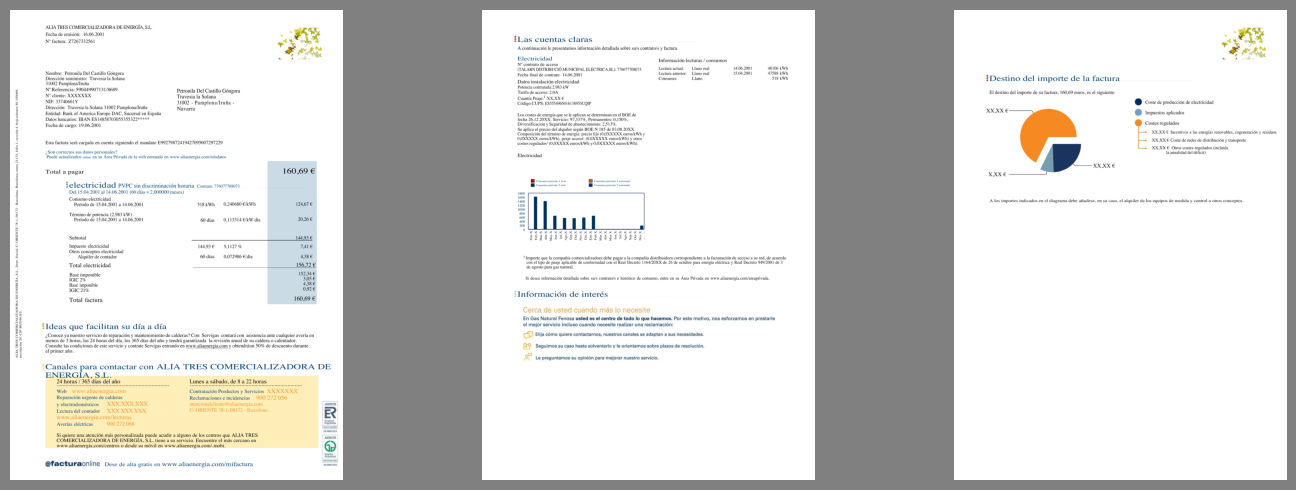

In [21]:

def pdf_to_images(pdf_path, output_dir, dpi=200, fmt="png"):

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Convert PDF to images
        pages = convert_from_path(pdf_path, dpi=dpi)

        # Save each page as an image
        for i, page in enumerate(pages):
            image_path = os.path.join(output_dir, f"page_{i+1}.{fmt}")
            page.save(image_path, fmt)
            print(f"Saved page {i+1} to {image_path}")

        print(f"Successfully converted {len(pages)} pages to images")

    except Exception as e:
        print(f"Error converting PDF: {str(e)}")


pdf_to_images("./data/example-utility.pdf", "./working files/pdf_images/")

# Create a figure with 3 subplots arranged horizontally
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('#808080')  # Set gray background for figure

# Load and display images in each subplot
img1 = mpimg.imread('./working files/pdf_images/page_1.png')
img2 = mpimg.imread('./working files/pdf_images/page_2.png') 
img3 = mpimg.imread('./working files/pdf_images/page_3.png')

ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)

# Remove axes for each subplot and set gray background
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_facecolor('#808080')
ax2.set_facecolor('#808080')
ax3.set_facecolor('#808080')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Extracting the data

Now that we have our utility bill images ready, let's move on to extracting the data we need. This process involves three key steps.

First, we need to define exactly what information we want to pull from the bill. In this example, we're interested in the total amount paid, the energy consumed during the billing period, and the contracted power. To do this, we'll create a Pydantic BaseModel called `UtilityInformation` with fields for each of these data points. Using Pydantic together with Instructor will ensure that the model's output conforms to this predefined structure, making it easy to work with the extracted data in our code.

Next, we need to upload the bill images to Gemini so that they can be referenced in our extraction prompt. One of the great things about working with Gemini is how seamlessly it handles multimodal data. Whether you're dealing with images, PDFs, audio files, or even videos, you can simply upload them and then reference them directly in your prompts. This makes Gemini a fantastic choice for extracting data from all kinds of document formats.

Finally, with our target data fields defined and images uploaded, we're ready to run the extraction query itself. We'll initialize a client using the Instructor wrapper and pass it our extraction prompt (including references to the uploaded images), the UtilityInformation model, and the response_model argument to ensure the output matches our desired schema.

By leveraging the power of Gemini and the structure provided by Pydantic and Instructor, we can cleanly extract the key data points from our complex utility bill. The resulting data will be neatly organized into the UtilityInformation format, ready for further analysis and use in our application.

The question though is whether the data will be all accurate, or whether some values will be incorrect!


In [25]:
# Define your output structure
class UtilityInformation(BaseModel):
    amount: float = Field(description="Total amount paid for the energy")
    energy: float = Field(description="Energy consumed in the period, in kWh")
    power: float = Field(description="Power contracted, in kW")

# Upload all image files first
print("----------")
images_dir = "./working files/pdf_images/"
uploaded_images = []
for filename in os.listdir(images_dir):
    if filename.endswith(".png"):
        print(f"Uploading file: {filename}")
        file_path = os.path.join(images_dir, filename)
        uploaded_images.append(genai.upload_file(file_path))

# Create prompt with instruction and uploaded images
prompt = [
    "Extract the amount paid, the energy consumed in the period and the power contracted."
]

prompt.extend(uploaded_images)

# Initialize the client
client = instructor.from_gemini(
    client=genai.GenerativeModel(
        model_name="models/" + MODEL,
    ),
    mode=instructor.Mode.GEMINI_JSON,
)

resp = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_model=UtilityInformation,
)
print("----------")
print(f"Amount: {resp.amount} €")
print(f"Energy: {resp.energy} kWh")
print(f"Power: {resp.power} kW")
print("----------")

----------
Uploading file: page_2.png
Uploading file: page_3.png
Uploading file: page_1.png
----------
Amount: 160.69
Energy: 518.0
Power: 2.0
----------


## Validating results

If we compare the results with the data in the document we can see that while the model correctly identified the Amount and Energy values, it seems to have "hallucinated" an incorrect value for the contracted Power. The true value, as seen in the original utility bill, is 2.983 kW. This is a perfect example of the challenge we discussed earlier - while multimodal models can better understand the layout from images, they can sometimes produce innacurate results.

There's a way to validate the extracted values and catch any potential hallucinations. The key lies in combining our knowledge of the expected data format (e.g., units of measurement) with Instructor's validation capabilities.

Here's the plan: we'll use a simple PDF reader to extract the raw text from the utility bill. Then, for each value returned by the model, we'll check if the  `value + units` string appears verbatim in the document text. For instance, if the model outputs `325` for the Energy consumption, we'll search the bill text for the exact string `325 kWh`. If the string is found, we can be confident that the extracted value is legitimate. If not, we'll flag it as a potential hallucination.

By implementing this validation step, we can enjoy the best of both worlds. On one hand, we leverage the power of vision-based extraction to understand the complex layout of the utility bill and identify the relevant data points. On the other hand, we cross-reference the extracted values against the raw text to ensure they are grounded in reality and not just figments of the model's imagination.

This approach showcases the flexibility and robustness of the Instructor framework. By combining cutting-edge AI techniques with smart validation strategies, we can build data extraction pipelines that are both highly accurate and resistant to the occasional hiccups of even the most advanced models.

In [32]:
# Define your output structure
class UtilityInformation(BaseModel):
    amount: float = Field(description="Total amount paid for the energy")
    energy: float = Field(description="Energy consumed in the period, in kWh")
    power: float = Field(description="Power contracted, in kW")

    validation_results: ClassVar[dict] = {}

    @classmethod
    def _validate_field(cls, value: float, field_name: str, unit: str, info) -> tuple:
        document_text = info.context.get("document_text")
        
        # prepare value to compare (change "." for "," and add units)
        str_num = f"{value:.5f}".rstrip("0").rstrip(".")
        value_to_compare = str_num.replace(".", ",") + f" {unit}"

        passed = value_to_compare in document_text
        if passed:
            print(f"The value extracted for <{field_name}>: {value} is correct!")
        else:
            print(
                f"The value extracted for <{field_name}>: {value} is not in the document."
            )

        cls.validation_results[field_name] = passed
        return value, passed

    @field_validator("amount")
    def validate_amount(cls, value, info):
        value, _ = cls._validate_field(value, info.field_name, "€", info)
        return value

    @field_validator("energy")
    def validate_energy(cls, value, info):
        value, _ = cls._validate_field(value, info.field_name, "kWh", info)
        return value

    @field_validator("power")
    def validate_power(cls, value, info):
        value, _ = cls._validate_field(value, info.field_name, "kW", info)
        return value


reader = PdfReader("./data/example-utility.pdf")
pages = reader.pages
document_text = " ".join(list(map(lambda page: page.extract_text(), pages)))


print("------ VALIDATED EXTRACTIONS ------")
resp = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_model=UtilityInformation,
    validation_context={"document_text": document_text},
)
print("")
print("------ FINAL RESULTS AND VALIDATIONS")
print(f"Amount: {resp.amount} (Validation: {resp.validation_results['amount']})")
print(f"Energy: {resp.energy} (Validation: {resp.validation_results['energy']})")
print(f"Power: {resp.power} (Validation: {resp.validation_results['power']})")

------ VALIDATED EXTRACTIONS ------
The value extracted for <amount>: 160.69 is correct!
The value extracted for <energy>: 518.0 is correct!
The value extracted for <power>: 2.0 is not in the document.

------ FINAL RESULTS AND VALIDATIONS
Amount: 160.69 (Validation: True)
Energy: 518.0 (Validation: True)
Power: 2.0 (Validation: False)


## General Comments and Takeaways

In this example, we've chosen to track the validation status of each extracted value and use that information later in the product or process to alert users to double-check potentially inaccurate results. This approach allows for manual correction of the data, which can then be fed back into the model as examples for future prompts. As we discussed in our previous post on [in-context learning / examples](https://www.limai.io/blog/example), this iterative refinement process can significantly boost the accuracy of the extraction over time.

An alternative strategy would be to raise an error when a value fails validation and leverage Instructor's automatic retry functionality to attempt to obtain a valid result from the model. However, in our experience with vision-based extraction, this approach didn't consistently lead to better outcomes. That said, depending on your specific use case and requirements, it could be worth exploring this option further.

You might be wondering whether sending the model both the raw text and the images, or just the text alone, would yield superior results. In this particular example, you're absolutely right - providing the full context would likely improve the accuracy of the extraction. However, it's worth noting that the workflow we've demonstrated here was originally developed for a more complex real-world scenario where this wasn't necessarily the case. Unfortunately, due to confidentiality constraints, we can't share all the details of that project here.

Nonetheless, we hope that this example has given you a taste of how relatively simple techniques can be used to enhance the robustness and accuracy of your LLM workflows. By starting with a basic pipeline and iteratively refining it based on validation feedback, you can gradually hone in on the level of quality and reliability required for your specific application.

As you experiment with these ideas in your own projects, remember that the key is to strike a balance between leveraging the impressive capabilities of models like Gemini and grounding their outputs in the realities of your data. By combining cutting-edge AI with common-sense validation strategies, you can create powerful, flexible, and trustworthy data extraction solutions that meet the unique needs of your business.

We can't wait to see what you build with these techniques! As always, feel free to reach out if you have any questions or if you'd like to share your own experiences and insights. Happy extracting!